In [1]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np
from utils import *

In [2]:
tex_fonts = {
    #source: https://jwalton.info/Embed-Publication-Matplotlib-Latex/
    # Use LaTeX to write all text
    "text.usetex": True,
    "font.family": "serif",
    # Use 10pt font in plots, to match 10pt font in document
    #"axes.labelsize": 10,
    "font.size": 10,
    # Make the legend/label fonts a little smaller
    "legend.fontsize": 8,
    "axes.titlesize": 10,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8,
    'text.latex.preamble': r"\usepackage{amsmath}"
}

In [3]:
import pandas as pd
import geopandas as gpd
from shapely import wkt

# Read the CSV file
csv_file = 'LondonLSOAs.csv'
df = pd.read_csv(csv_file)

# Convert the 'geometry' column to Shapely geometry objects
df['geometry'] = df['geometry'].apply(wkt.loads)

# Create the GeoDataFrame
gdf = gpd.GeoDataFrame(df, geometry='geometry')

# Display the GeoDataFrame to ensure it's correct
print(gdf.head())

                    LSOA21NM   centroid_x   centroid_y  c_percent asian  \
0        City of London 001A  532151.1942  181615.2014         0.107191   
1        City of London 001B  532443.6860  181645.7249         0.130592   
2        City of London 001C  532207.0148  182030.1296         0.094913   
3        City of London 001E  533618.3485  181157.3543         0.321526   
4  Barking and Dagenham 016A  544934.3697  184297.5465         0.479675   

   c_percent black  c_percent mixed  c_percent white  c_percent sikh  \
0         0.007463         0.037992         0.801221        0.000000   
1         0.007937         0.043290         0.782107        0.000000   
2         0.034739         0.062655         0.741315        0.001860   
3         0.108084         0.071753         0.385104        0.000000   
4         0.108401         0.037940         0.327913        0.036295   

   c_percent hindu  c_percent christian  ...  o_opioids_quantity_per_capita  \
0         0.026441             0.3457

# 测试不同网络 -- phd方法 - 两层网络

In [4]:
import pandas as pd
import geopandas as gpd
from shapely import wkt
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from scipy.spatial import distance_matrix
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn.functional as F
from torch_geometric.nn import GINConv, global_add_pool
from torch_geometric.utils import from_networkx
from statsmodels.stats.outliers_influence import variance_inflation_factor
import random
import itertools
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

## 两层网络

C:\Users\0\AppData\Local\Temp\ipykernel_27080\612648604.py:12: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['geo_centroid'] = gdf.centroid


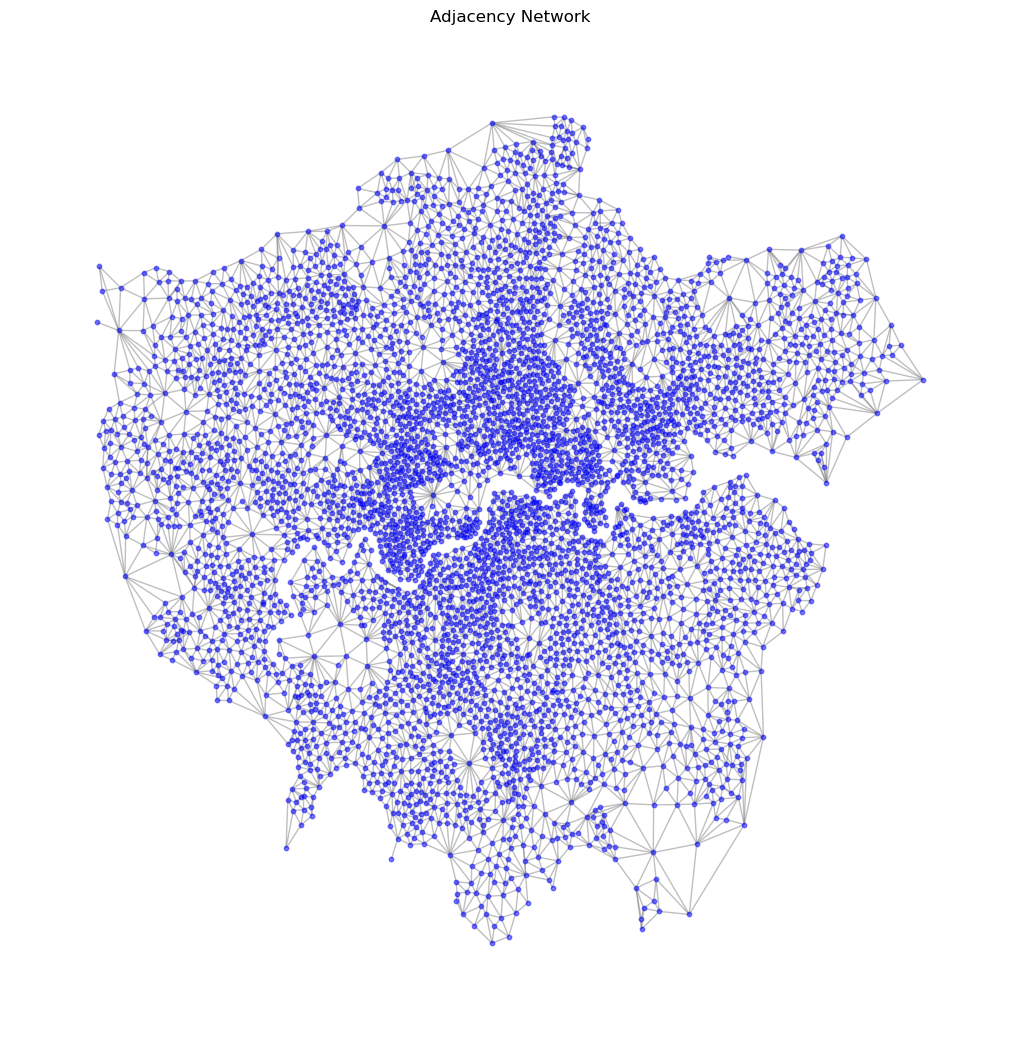

In [5]:
# 读取CSV文件并创建GeoDataFrame
csv_file = 'LondonLSOAs.csv'
df = pd.read_csv(csv_file)

# 创建几何对象（假设geometry列包含WKT格式的多边形数据）
gdf = gpd.GeoDataFrame(df, geometry=gpd.GeoSeries.from_wkt(df['geometry']))

# 设置坐标系 (假设是WGS84坐标系)
gdf.set_crs(epsg=4326, inplace=True)

# 计算每个LSOA的几何中心点
gdf['geo_centroid'] = gdf.centroid

# 计算相邻关系
neighbors = gpd.sjoin(gdf, gdf, how='left', predicate='intersects')

# 手动处理索引
neighbors = neighbors[neighbors.index != neighbors.index_right]

# 构建邻接矩阵
G = nx.Graph()

# 添加节点
for idx, row in gdf.iterrows():
    G.add_node(idx, pos=(row.geo_centroid.x, row.geo_centroid.y))

# 添加边，根据相邻关系
for idx, row in neighbors.iterrows():
    G.add_edge(row.name, row['index_right'], weight=1)

# 可视化邻接关系
pos = nx.get_node_attributes(G, 'pos')
plt.figure(figsize=(10, 10))
nx.draw(G, pos, node_size=10, node_color='blue', edge_color='grey', alpha=0.5)
plt.title("Adjacency Network")
plt.show()

C:\Users\0\AppData\Local\Temp\ipykernel_11724\2613878886.py:21: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['geo_centroid'] = gdf.centroid


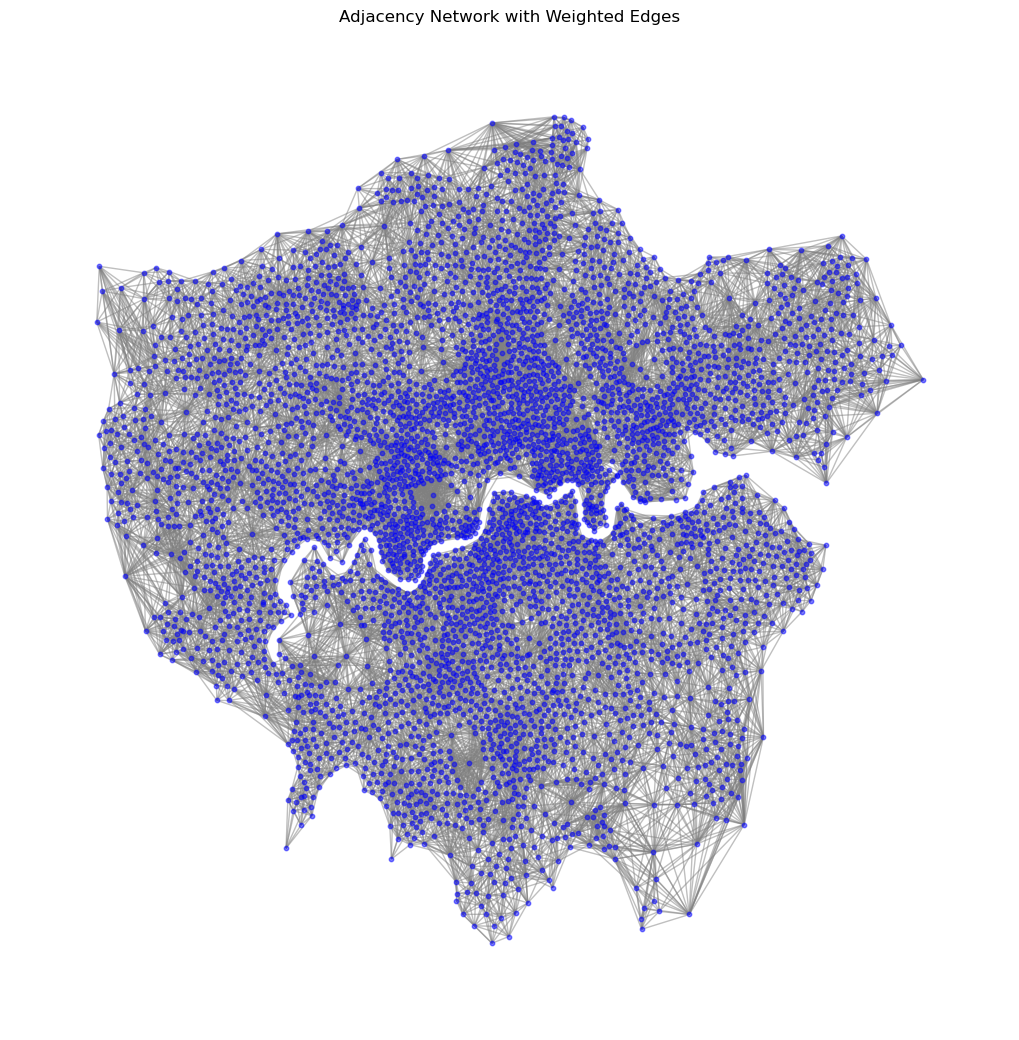

In [2]:
import pandas as pd
import geopandas as gpd
from shapely import wkt
import numpy as np
from scipy.spatial import distance_matrix
import networkx as nx
import matplotlib.pyplot as plt

# 读取CSV文件
csv_file = 'LondonLSOAs.csv'
df = pd.read_csv(csv_file)

# 创建GeoDataFrame
df['geometry'] = df['geometry'].apply(wkt.loads)
gdf = gpd.GeoDataFrame(df, geometry='geometry')

# 设置坐标系 (假设是WGS84坐标系)
gdf.set_crs(epsg=4326, inplace=True)

# 计算几何中心点
gdf['geo_centroid'] = gdf.centroid
coords = np.array(list(zip(gdf.geo_centroid.x, gdf.geo_centroid.y)))

# 计算相邻关系
neighbors = gpd.sjoin(gdf, gdf, how='left', predicate='intersects')
neighbors = neighbors[neighbors.index != neighbors.index_right]

# 计算中心点之间的距离
dist_matrix = distance_matrix(coords, coords)

# 创建邻居关系字典
first_level_neighbors = {i: [] for i in range(len(gdf))}
second_level_neighbors = {i: set() for i in range(len(gdf))}

for idx, row in neighbors.iterrows():
    first_level_neighbors[row.name].append(row['index_right'])

# 查找第二层邻居
for i in first_level_neighbors:
    for first_neighbor in first_level_neighbors[i]:
        second_level_neighbors[i].update(first_level_neighbors[first_neighbor])
    second_level_neighbors[i].discard(i)
    second_level_neighbors[i].difference_update(first_level_neighbors[i])

# 构建网络并根据距离倒数设置权重
G = nx.Graph()

# 添加节点
for idx, row in gdf.iterrows():
    G.add_node(idx, pos=(row.geo_centroid.x, row.geo_centroid.y))

# 添加第一层邻居的边，权重高
for idx, neighbors in first_level_neighbors.items():
    for neighbor in neighbors:
        if dist_matrix[idx][neighbor] > 0:  # 确保距离有效
            G.add_edge(idx, neighbor, weight=1 / dist_matrix[idx][neighbor])

# 添加第二层邻居的边，权重低
for idx, neighbors in second_level_neighbors.items():
    for neighbor in neighbors:
        if dist_matrix[idx][neighbor] > 0:  # 确保距离有效
            G.add_edge(idx, neighbor, weight=0.5 / dist_matrix[idx][neighbor])  # 权重较低

# 可视化邻接关系
pos = nx.get_node_attributes(G, 'pos')
plt.figure(figsize=(10, 10))
nx.draw(G, pos, node_size=10, node_color='blue', edge_color='grey', alpha=0.5)
plt.title("Adjacency Network with Weighted Edges")
plt.show()


# 变量选择问题 -- 固定控制变量（所有的年龄段） + 寻找尽可能低的VIF变量组

In [6]:
# 读取CSV文件并创建GeoDataFrame
csv_file = 'LondonLSOAs.csv'
df = pd.read_csv(csv_file)

# 创建几何对象（假设geometry列包含WKT格式的多边形数据）
gdf = gpd.GeoDataFrame(df, geometry=gpd.GeoSeries.from_wkt(df['geometry']))

# 设置坐标系 (假设是WGS84坐标系)
gdf.set_crs(epsg=4326, inplace=True)

# 固定选取的变量
fixed_columns = [
    'c_percent Aged 10 to 14 years', 'c_percent Aged 15 to 19 years',
       'c_percent Aged 20 to 24 years', 'c_percent Aged 25 to 29 years',
       'c_percent Aged 30 to 34 years', 'c_percent Aged 35 to 39 years',
       'c_percent Aged 40 to 44 years', 'c_percent Aged 65 to 69 years',
       'c_percent Aged 70 to 74 years', 'c_percent Aged 75 to 79 years',
       'c_percent Aged 80 to 84 years', 'c_percent Aged 85 years and over',
       'c_percent mixed', 'c_percent white',
       'c_percent 2. Professional occupations', 'c_pop_density', 'e_NO2',
       'e_ndvi', 'e_water', 'e_trees', 'e_grass', 'e_bare', 'c_percent asian',
       'c_percent black', 'c_percent buddhist', 'c_percent muslim',
       'c_percent no central heating', 'c_percent communal heating',
       'c_percent TFW less than 2km', 'c_percent 49 or more hours worked',
       'c_percent commute on foot', 'c_percent commute metro rail',
       'c_percent commute bus', 'c_percent commute bicycle',
       'c_percent student moved to address',
       'c_percent occupancy rating bedrooms -2',
       'c_percent occupancy rating bedrooms -1', 'c_percent 10 years or more',
       'c_percent 2 years or more but less than 5 years',
       'c_percent 5 years or more but less than 10 years',
       # 'c_percent married or in a registered civil partnership married same sex',
       'c_percent married or in a registered civil partnership in a registered civil partnership',
       'c_percent separated but still legally married or still legally in a civil partnership separated but still in a registered civil partnership',
       'c_percent divorced or civil partnership dissolved formerly in a civil partnership now legally dissolved',
       'c_percent   cannot speak english well',
       'c_percent   cannot speak english',
       'c_percent households deprived in four dimensions',
       'c_percent christian', 'c_percent WFH', 'c_percent part-time',
       'c_percent commute train', 'c_percent outside UK moved to address',
       'c_percent occupancy rating bedrooms +2',
       'c_percent 3. Associate professional and technical occupations',
       'c_percent 5. Skilled trades occupations',
       'c_percent 6. Caring leisure and other service occupations',
       'c_percent divorced or civil partnership dissolved',
       'e_lake_mix_layer_depth', 'e_snow_cover', 'e_surface_runoff_sum',
       'e_snow_and_ice', 'e_crops', 'e_evaporation_from_the_top_of_canopy_sum',
       'e_shrub_and_scrub'
]

# 提取固定变量
fixed_features = gdf[fixed_columns].apply(pd.to_numeric, errors='coerce')

# 使用邻接节点的均值填充空值
for i, row in fixed_features.iterrows():
    for col in fixed_columns:
        if pd.isna(row[col]):
            neighbor_indices = list(G.neighbors(i))
            if neighbor_indices:  # 确保有邻居
                neighbor_values = fixed_features.iloc[neighbor_indices][col]
                mean_value = neighbor_values.mean()
                if pd.isna(mean_value):
                    mean_value = fixed_features[col].mean()  # 如果邻居的均值还是nan，使用全局均值填充
                fixed_features.at[i, col] = mean_value
            else:
                fixed_features.at[i, col] = fixed_features[col].mean()  # 如果没有邻居，使用全局均值填充

# 再次检查是否有任何nan值
print("Remaining NaN count:", fixed_features.isna().sum().sum())

# 计算VIF
def calculate_vif(df):
    vif = pd.DataFrame()
    vif["Variable"] = df.columns
    vif["VIF"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
    return vif

vif_df = calculate_vif(fixed_features)
print(vif_df)

# 进行标准化
scaler = StandardScaler()
final_features_scaled = scaler.fit_transform(fixed_features)
final_features_tensor = torch.tensor(final_features_scaled, dtype=torch.float)

# 准备目标变量
target_column = 'o_depression_quantity_per_capita'
target = gdf[target_column].apply(pd.to_numeric, errors='coerce').fillna(0)
targets = torch.tensor(target.values, dtype=torch.float).unsqueeze(1)  # 添加维度以匹配模型输出

# 将 NetworkX 图转换为 PyTorch Geometric 数据
from torch_geometric.utils import from_networkx
data = from_networkx(G)
data.x = final_features_tensor
data.y = targets

Remaining NaN count: 0
                                             Variable         VIF
0                       c_percent Aged 10 to 14 years   47.337738
1                       c_percent Aged 15 to 19 years   17.964352
2                       c_percent Aged 20 to 24 years   35.844044
3                       c_percent Aged 25 to 29 years   37.354234
4                       c_percent Aged 30 to 34 years   58.088410
5                       c_percent Aged 35 to 39 years   73.285812
6                       c_percent Aged 40 to 44 years   73.637442
7                       c_percent Aged 65 to 69 years   35.718904
8                       c_percent Aged 70 to 74 years   34.047895
9                       c_percent Aged 75 to 79 years   26.720948
10                      c_percent Aged 80 to 84 years   19.927258
11                   c_percent Aged 85 years and over   10.234138
12                                    c_percent mixed   21.919998
13                                    c_percent white

# GIN测试

## o_depression_quantity_per_capita


Best params: {'lr': 0.01, 'weight_decay': 0.0005, 'hidden1': 32, 'hidden2': 64, 'dropout': 0.3, 'num_epochs': 200}, Best loss: 20.8215
MSE: 17.8378
RMSE: 4.2235
MAE: 3.1364
R²: 0.7860


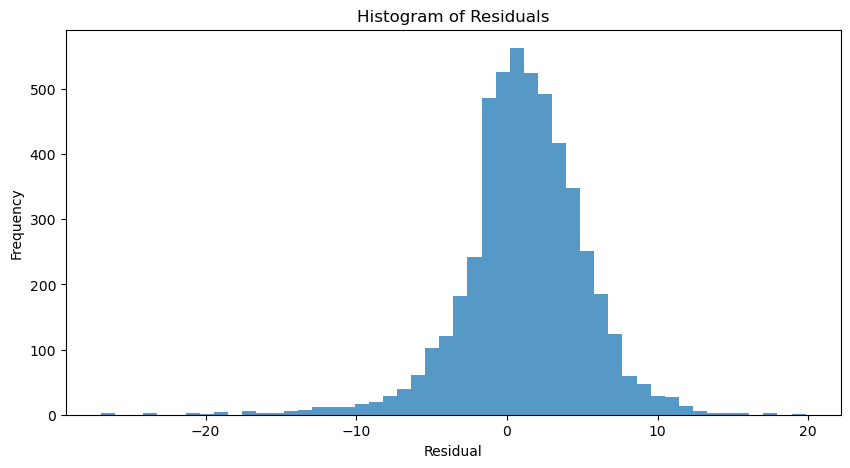

In [14]:
# 定义GIN模型
class GIN(torch.nn.Module):
    def __init__(self, in_channels, hidden1, hidden2, out_channels, dropout):
        super(GIN, self).__init__()
        nn1 = torch.nn.Sequential(torch.nn.Linear(in_channels, hidden1), torch.nn.ReLU(), torch.nn.Linear(hidden1, hidden1))
        self.conv1 = GINConv(nn1)
        nn2 = torch.nn.Sequential(torch.nn.Linear(hidden1, hidden2), torch.nn.ReLU(), torch.nn.Linear(hidden2, hidden2))
        self.conv2 = GINConv(nn2)
        self.fc1 = torch.nn.Linear(hidden2, out_channels)
        self.dropout = dropout

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.fc1(x)
        return x

# 训练函数
def train(model, optimizer, data):
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = F.mse_loss(out, data.y)
    loss.backward()
    optimizer.step()
    return loss.item()

# 定义超参数空间
param_space = {
    'lr': [0.001, 0.005, 0.01],
    'weight_decay': [5e-4, 1e-3, 5e-3],
    'hidden1': [32, 64, 128],
    'hidden2': [16, 32, 64],
    'dropout': [0.3, 0.5, 0.7],
    'num_epochs': [100, 200]
}

# 随机搜索
num_samples = 20
random_params = [dict(zip(param_space, v)) for v in random.sample(list(itertools.product(*param_space.values())), num_samples)]

best_loss = float('inf')
best_params = None

for params in random_params:
    model = GIN(
        in_channels=data.x.shape[1], 
        hidden1=params['hidden1'], 
        hidden2=params['hidden2'], 
        out_channels=data.y.shape[1], 
        dropout=params['dropout']
    )
    optimizer = torch.optim.Adam(model.parameters(), lr=params['lr'], weight_decay=params['weight_decay'])

    losses = []
    for epoch in range(params['num_epochs']):
        loss = train(model, optimizer, data)
        losses.append(loss)

    if losses[-1] < best_loss:
        best_loss = losses[-1]
        best_params = params

print(f'Best params: {best_params}, Best loss: {best_loss:.4f}')

# 使用最佳超参数重新训练模型
model = GIN(
    in_channels=data.x.shape[1], 
    hidden1=best_params['hidden1'], 
    hidden2=best_params['hidden2'], 
    out_channels=data.y.shape[1], 
    dropout=best_params['dropout']
)
optimizer = torch.optim.Adam(model.parameters(), lr=best_params['lr'], weight_decay=best_params['weight_decay'])

losses = []
for epoch in range(best_params['num_epochs']):
    loss = train(model, optimizer, data)
    losses.append(loss)

# 测试模型并计算评估指标
model.eval()
with torch.no_grad():
    pred = model(data)
    residuals = data.y - pred

# 计算评估指标
y_true = data.y.detach().numpy()
y_pred = pred.detach().numpy()

mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print(f'MSE: {mse:.4f}')
print(f'RMSE: {rmse:.4f}')
print(f'MAE: {mae:.4f}')
print(f'R²: {r2:.4f}')

# 可视化残差
plt.figure(figsize=(10, 5))
plt.hist(residuals.detach().numpy(), bins=50, alpha=0.75)
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals')
plt.show()

Best params: {'lr': 0.01, 'weight_decay': 0.005, 'hidden1': 64, 'hidden2': 32, 'dropout': 0.3, 'num_epochs': 200}, Best loss: 34.5868
MSE: 22.3230
RMSE: 4.7247
MAE: 3.5873
R²: 0.7322


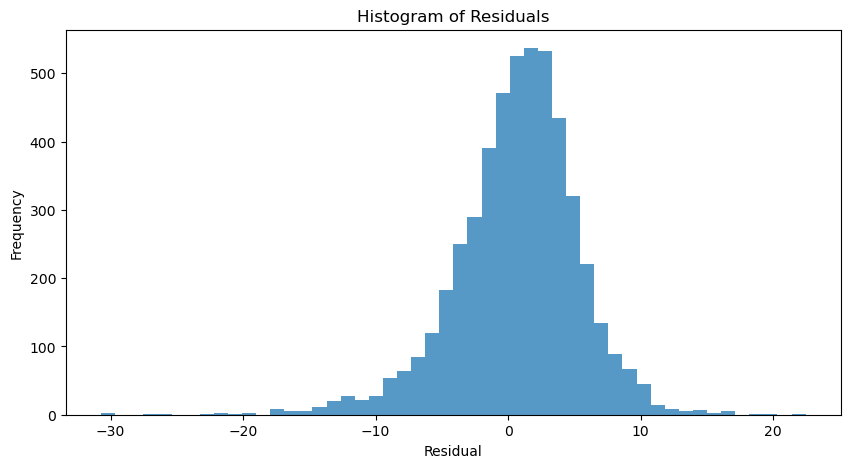

In [11]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GATConv
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import random
import itertools

class GAT(torch.nn.Module):
    def __init__(self, in_channels, hidden1, hidden2, out_channels, dropout, heads=1):
        super(GAT, self).__init__()
        self.conv1 = GATConv(in_channels, hidden1, heads=heads, dropout=dropout)
        self.conv2 = GATConv(hidden1 * heads, hidden2, heads=heads, dropout=dropout)
        self.fc1 = torch.nn.Linear(hidden2 * heads, out_channels)
        self.dropout = dropout

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)  # Dropout
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)  # Dropout
        x = self.fc1(x)
        return x

def train(model, optimizer, data):
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = F.mse_loss(out, data.y)
    loss.backward()
    optimizer.step()
    return loss.item()

# 定义超参数空间
param_space = {
    'lr': [0.001, 0.005, 0.01],
    'weight_decay': [5e-4, 1e-3, 5e-3],
    'hidden1': [32, 64, 128],
    'hidden2': [16, 32, 64],
    'dropout': [0.3, 0.5, 0.7],
    'num_epochs': [100, 200]
}

# 随机搜索
num_samples = 20  # 选择搜索的参数组合数量
random_params = [dict(zip(param_space, v)) for v in random.sample(list(itertools.product(*param_space.values())), num_samples)]

best_loss = float('inf')
best_params = None

for params in random_params:
    model = GAT(
        in_channels=data.x.shape[1], 
        hidden1=params['hidden1'], 
        hidden2=params['hidden2'], 
        out_channels=data.y.shape[1], 
        dropout=params['dropout']
    )
    optimizer = torch.optim.Adam(model.parameters(), lr=params['lr'], weight_decay=params['weight_decay'])

    losses = []
    for epoch in range(params['num_epochs']):
        loss = train(model, optimizer, data)
        losses.append(loss)

    if losses[-1] < best_loss:
        best_loss = losses[-1]
        best_params = params

print(f'Best params: {best_params}, Best loss: {best_loss:.4f}')

# 使用最佳超参数重新训练模型
model = GAT(
    in_channels=data.x.shape[1], 
    hidden1=best_params['hidden1'], 
    hidden2=best_params['hidden2'], 
    out_channels=data.y.shape[1], 
    dropout=best_params['dropout']
)
optimizer = torch.optim.Adam(model.parameters(), lr=best_params['lr'], weight_decay=best_params['weight_decay'])

losses = []
for epoch in range(best_params['num_epochs']):
    loss = train(model, optimizer, data)
    losses.append(loss)

# 测试模型并计算评估指标
model.eval()
with torch.no_grad():
    pred = model(data)
    residuals = data.y - pred

# 计算评估指标
y_true = data.y.detach().numpy()
y_pred = pred.detach().numpy()

mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print(f'MSE: {mse:.4f}')
print(f'RMSE: {rmse:.4f}')
print(f'MAE: {mae:.4f}')
print(f'R²: {r2:.4f}')

# 可视化残差
plt.figure(figsize=(10, 5))
plt.hist(residuals.detach().numpy(), bins=50, alpha=0.75)
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals')
plt.show()

Best params: {'lr': 0.01, 'weight_decay': 0.001, 'hidden1': 64, 'hidden2': 64, 'dropout': 0.5, 'num_epochs': 200}, Best loss: 35.5924
MSE: 24.3629
RMSE: 4.9359
MAE: 3.8316
R²: 0.7077


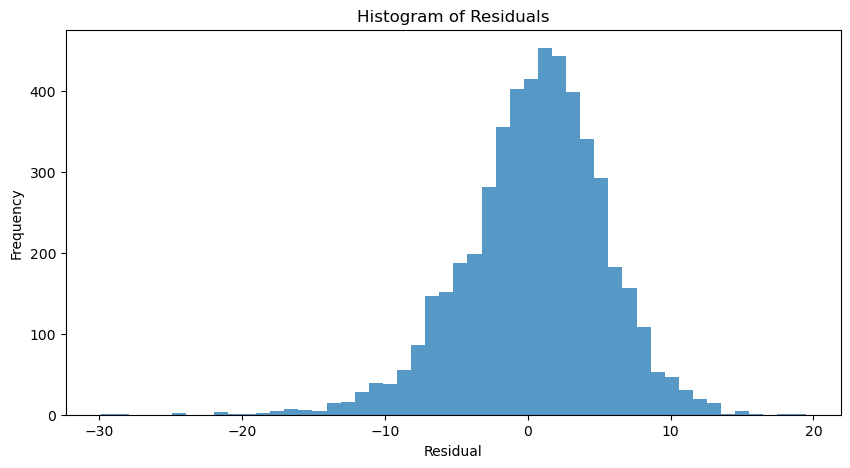

In [12]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import random
import itertools

class GraphSAGE(torch.nn.Module):
    def __init__(self, in_channels, hidden1, hidden2, out_channels, dropout):
        super(GraphSAGE, self).__init__()
        self.conv1 = SAGEConv(in_channels, hidden1)
        self.conv2 = SAGEConv(hidden1, hidden2)
        self.fc1 = torch.nn.Linear(hidden2, out_channels)
        self.dropout = dropout

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)  # Dropout
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)  # Dropout
        x = self.fc1(x)
        return x

def train(model, optimizer, data):
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = F.mse_loss(out, data.y)
    loss.backward()
    optimizer.step()
    return loss.item()

# 定义超参数空间
param_space = {
    'lr': [0.001, 0.005, 0.01],
    'weight_decay': [5e-4, 1e-3, 5e-3],
    'hidden1': [32, 64, 128],
    'hidden2': [16, 32, 64],
    'dropout': [0.3, 0.5, 0.7],
    'num_epochs': [100, 200]
}

# 随机搜索
num_samples = 20  # 选择搜索的参数组合数量
random_params = [dict(zip(param_space, v)) for v in random.sample(list(itertools.product(*param_space.values())), num_samples)]

best_loss = float('inf')
best_params = None

for params in random_params:
    model = GraphSAGE(
        in_channels=data.x.shape[1], 
        hidden1=params['hidden1'], 
        hidden2=params['hidden2'], 
        out_channels=data.y.shape[1], 
        dropout=params['dropout']
    )
    optimizer = torch.optim.Adam(model.parameters(), lr=params['lr'], weight_decay=params['weight_decay'])

    losses = []
    for epoch in range(params['num_epochs']):
        loss = train(model, optimizer, data)
        losses.append(loss)

    if losses[-1] < best_loss:
        best_loss = losses[-1]
        best_params = params

print(f'Best params: {best_params}, Best loss: {best_loss:.4f}')

# 使用最佳超参数重新训练模型
model = GraphSAGE(
    in_channels=data.x.shape[1], 
    hidden1=best_params['hidden1'], 
    hidden2=best_params['hidden2'], 
    out_channels=data.y.shape[1], 
    dropout=best_params['dropout']
)
optimizer = torch.optim.Adam(model.parameters(), lr=best_params['lr'], weight_decay=best_params['weight_decay'])

losses = []
for epoch in range(best_params['num_epochs']):
    loss = train(model, optimizer, data)
    losses.append(loss)

# 测试模型并计算评估指标
model.eval()
with torch.no_grad():
    pred = model(data)
    residuals = data.y - pred

# 计算评估指标
y_true = data.y.detach().numpy()
y_pred = pred.detach().numpy()

mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print(f'MSE: {mse:.4f}')
print(f'RMSE: {rmse:.4f}')
print(f'MAE: {mae:.4f}')
print(f'R²: {r2:.4f}')

# 可视化残差
plt.figure(figsize=(10, 5))
plt.hist(residuals.detach().numpy(), bins=50, alpha=0.75)
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals')
plt.show()

Best params: {'lr': 0.005, 'weight_decay': 0.005, 'hidden1': 32, 'hidden2': 32, 'dropout': 0.3, 'num_epochs': 200}, Best loss: 38.8391
MSE: 31.5853
RMSE: 5.6201
MAE: 4.3774
R²: 0.6211


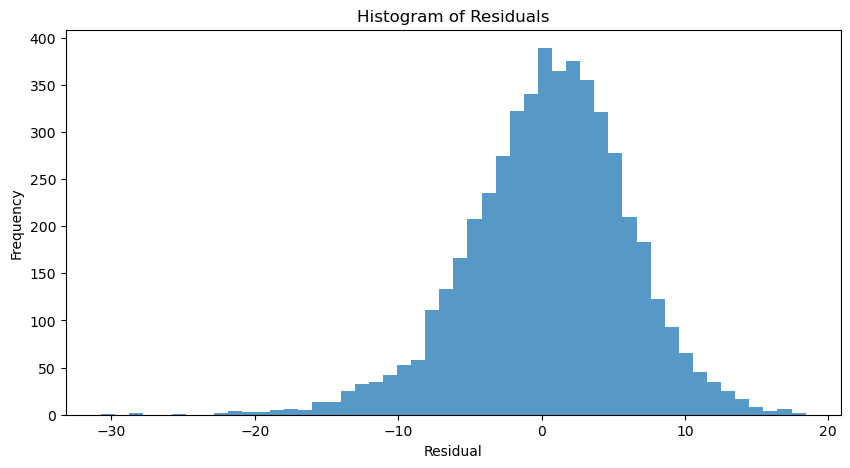

In [18]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import random
import itertools
import matplotlib.pyplot as plt

class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden1, hidden2, out_channels, dropout):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden1)
        self.conv2 = GCNConv(hidden1, hidden2)
        self.fc1 = torch.nn.Linear(hidden2, out_channels)
        self.dropout = dropout

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)  # Dropout
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)  # Dropout
        x = self.fc1(x)
        return x

def train(model, optimizer, data):
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = F.mse_loss(out, data.y)
    loss.backward()
    optimizer.step()
    return loss.item()

# 定义超参数空间
param_space = {
    'lr': [0.001, 0.005, 0.01],
    'weight_decay': [5e-4, 1e-3, 5e-3],
    'hidden1': [32, 64, 128],
    'hidden2': [16, 32, 64],
    'dropout': [0.3, 0.5, 0.7],
    'num_epochs': [100, 200]
}

# 随机搜索
num_samples = 20  # 选择搜索的参数组合数量
random_params = [dict(zip(param_space, v)) for v in random.sample(list(itertools.product(*param_space.values())), num_samples)]

best_loss = float('inf')
best_params = None

for params in random_params:
    model = GCN(
        in_channels=data.x.shape[1], 
        hidden1=params['hidden1'], 
        hidden2=params['hidden2'], 
        out_channels=data.y.shape[1], 
        dropout=params['dropout']
    )
    optimizer = torch.optim.Adam(model.parameters(), lr=params['lr'], weight_decay=params['weight_decay'])

    losses = []
    for epoch in range(params['num_epochs']):
        loss = train(model, optimizer, data)
        losses.append(loss)

    if losses[-1] < best_loss:
        best_loss = losses[-1]
        best_params = params

print(f'Best params: {best_params}, Best loss: {best_loss:.4f}')

# 使用最佳超参数重新训练模型
model = GCN(
    in_channels=data.x.shape[1], 
    hidden1=best_params['hidden1'], 
    hidden2=best_params['hidden2'], 
    out_channels=data.y.shape[1], 
    dropout=best_params['dropout']
)
optimizer = torch.optim.Adam(model.parameters(), lr=best_params['lr'], weight_decay=best_params['weight_decay'])

losses = []
for epoch in range(best_params['num_epochs']):
    loss = train(model, optimizer, data)
    losses.append(loss)

# 测试模型并计算评估指标
model.eval()
with torch.no_grad():
    pred = model(data)
    residuals = data.y - pred

# 计算评估指标
y_true = data.y.detach().numpy()
y_pred = pred.detach().numpy()

mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print(f'MSE: {mse:.4f}')
print(f'RMSE: {rmse:.4f}')
print(f'MAE: {mae:.4f}')
print(f'R²: {r2:.4f}')

# 可视化残差
plt.figure(figsize=(10, 5))
plt.hist(residuals.detach().numpy(), bins=50, alpha=0.75)
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals')
plt.show()


Running configuration 1/50: {'lr': 0.005, 'weight_decay': 0.0005, 'hidden1': 32, 'dropout': 0.5, 'num_epochs': 200}
Configuration 1/50 finished with final loss: 45.6548
Running configuration 2/50: {'lr': 0.005, 'weight_decay': 0.0005, 'hidden1': 128, 'dropout': 0.5, 'num_epochs': 200}
Configuration 2/50 finished with final loss: 22.8739
Running configuration 3/50: {'lr': 0.005, 'weight_decay': 0.001, 'hidden1': 64, 'dropout': 0.3, 'num_epochs': 200}
Configuration 3/50 finished with final loss: 32.3031
Running configuration 4/50: {'lr': 0.005, 'weight_decay': 0.001, 'hidden1': 128, 'dropout': 0.5, 'num_epochs': 200}
Configuration 4/50 finished with final loss: 24.9733
Running configuration 5/50: {'lr': 0.01, 'weight_decay': 0.0005, 'hidden1': 64, 'dropout': 0.7, 'num_epochs': 200}
Configuration 5/50 finished with final loss: 35.9605
Running configuration 6/50: {'lr': 0.005, 'weight_decay': 0.005, 'hidden1': 32, 'dropout': 0.3, 'num_epochs': 200}
Configuration 6/50 finished with final lo

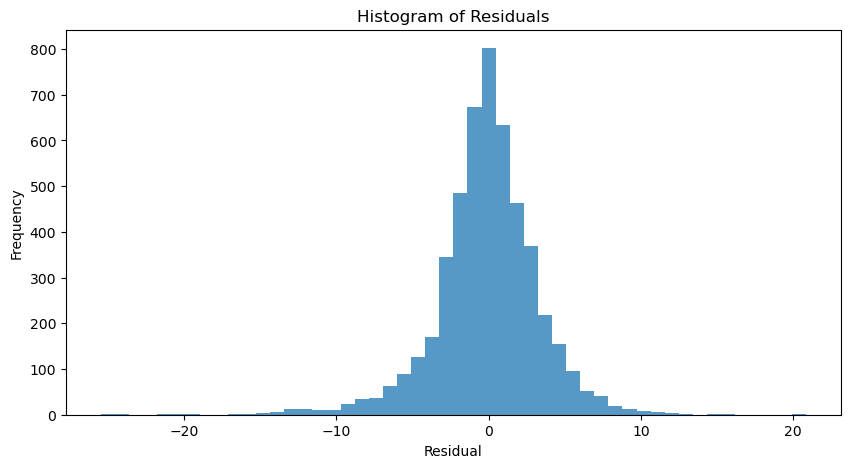

In [10]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GATv2Conv
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import random
import itertools
import matplotlib.pyplot as plt

class GATv2_OneLayer(torch.nn.Module):
    def __init__(self, in_channels, hidden1, out_channels, dropout):
        super(GATv2_OneLayer, self).__init__()
        self.conv1 = GATv2Conv(in_channels, hidden1, heads=1)
        self.fc1 = torch.nn.Linear(hidden1, out_channels)
        self.dropout = dropout

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)  # Dropout
        x = self.fc1(x)
        return x

def train(model, optimizer, data):
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = F.mse_loss(out, data.y)
    loss.backward()
    optimizer.step()
    return loss.item()

# 定义超参数空间
param_space = {
    'lr': [0.001, 0.005, 0.01],
    'weight_decay': [5e-4, 1e-3, 5e-3],
    'hidden1': [32, 64, 128],
    'dropout': [0.3, 0.5, 0.7],
    'num_epochs': [200]
}

# 随机搜索
num_samples = 50  # 选择搜索的参数组合数量
random_params = [dict(zip(param_space, v)) for v in random.sample(list(itertools.product(*param_space.values())), num_samples)]

best_loss = float('inf')
best_params = None

for i, params in enumerate(random_params):
    print(f"Running configuration {i + 1}/{num_samples}: {params}")
    
    model = GATv2_OneLayer(
        in_channels=data.x.shape[1], 
        hidden1=params['hidden1'], 
        out_channels=data.y.shape[1], 
        dropout=params['dropout']
    )
    optimizer = torch.optim.Adam(model.parameters(), lr=params['lr'], weight_decay=params['weight_decay'])

    losses = []
    for epoch in range(params['num_epochs']):
        loss = train(model, optimizer, data)
        losses.append(loss)

    print(f"Configuration {i + 1}/{num_samples} finished with final loss: {losses[-1]:.4f}")

    if losses[-1] < best_loss:
        best_loss = losses[-1]
        best_params = params

print(f'Best params: {best_params}, Best loss: {best_loss:.4f}')

# 使用最佳超参数重新训练模型
model = GATv2_OneLayer(
    in_channels=data.x.shape[1], 
    hidden1=best_params['hidden1'], 
    out_channels=data.y.shape[1], 
    dropout=best_params['dropout']
)
optimizer = torch.optim.Adam(model.parameters(), lr=best_params['lr'], weight_decay=best_params['weight_decay'])

losses = []
for epoch in range(best_params['num_epochs']):
    loss = train(model, optimizer, data)
    losses.append(loss)

# 测试模型并计算评估指标
model.eval()
with torch.no_grad():
    pred = model(data)
    residuals = data.y - pred

# 计算评估指标
y_true = data.y.detach().numpy()
y_pred = pred.detach().numpy()

mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print(f'MSE: {mse:.4f}')
print(f'RMSE: {rmse:.4f}')
print(f'MAE: {mae:.4f}')
print(f'R²: {r2:.4f}')

# 可视化残差
plt.figure(figsize=(10, 5))
plt.hist(residuals.detach().numpy(), bins=50, alpha=0.75)
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals')
plt.show()


Running configuration 1/50: {'lr': 0.001, 'weight_decay': 0.0005, 'hidden1': 64, 'hidden2': 64, 'dropout': 0.7, 'num_epochs': 200}
Configuration 1/50 finished with final loss: 59.3807
Running configuration 2/50: {'lr': 0.005, 'weight_decay': 0.005, 'hidden1': 64, 'hidden2': 16, 'dropout': 0.7, 'num_epochs': 200}
Configuration 2/50 finished with final loss: 82.4185
Running configuration 3/50: {'lr': 0.001, 'weight_decay': 0.001, 'hidden1': 128, 'hidden2': 32, 'dropout': 0.7, 'num_epochs': 200}
Configuration 3/50 finished with final loss: 78.5765
Running configuration 4/50: {'lr': 0.005, 'weight_decay': 0.0005, 'hidden1': 128, 'hidden2': 16, 'dropout': 0.7, 'num_epochs': 200}
Configuration 4/50 finished with final loss: 85.1635
Running configuration 5/50: {'lr': 0.001, 'weight_decay': 0.0005, 'hidden1': 64, 'hidden2': 16, 'dropout': 0.7, 'num_epochs': 200}
Configuration 5/50 finished with final loss: 104.5354
Running configuration 6/50: {'lr': 0.001, 'weight_decay': 0.005, 'hidden1': 128

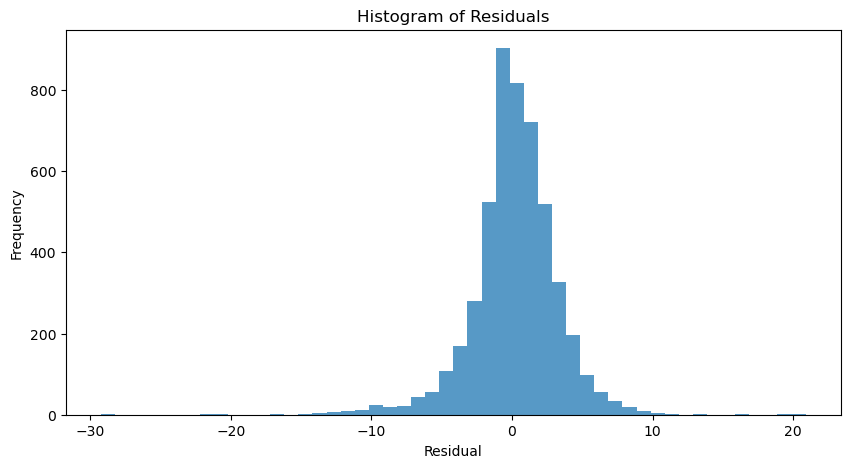

In [11]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GATv2Conv
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import random
import itertools
import matplotlib.pyplot as plt

class GATv2_TwoLayer(torch.nn.Module):
    def __init__(self, in_channels, hidden1, hidden2, out_channels, dropout):
        super(GATv2_TwoLayer, self).__init__()
        self.conv1 = GATv2Conv(in_channels, hidden1, heads=1)
        self.conv2 = GATv2Conv(hidden1, hidden2, heads=1)
        self.fc1 = torch.nn.Linear(hidden2, out_channels)
        self.dropout = dropout

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)  # Dropout
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)  # Dropout
        x = self.fc1(x)
        return x

def train(model, optimizer, data):
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = F.mse_loss(out, data.y)
    loss.backward()
    optimizer.step()
    return loss.item()

# 定义超参数空间
param_space = {
    'lr': [0.001, 0.005, 0.01],
    'weight_decay': [5e-4, 1e-3, 5e-3],
    'hidden1': [32, 64, 128],
    'hidden2': [16, 32, 64],
    'dropout': [0.3, 0.5, 0.7],
    'num_epochs': [200]
}

# 随机搜索
num_samples = 50  # 选择搜索的参数组合数量
random_params = [dict(zip(param_space, v)) for v in random.sample(list(itertools.product(*param_space.values())), num_samples)]

best_loss = float('inf')
best_params = None

for i, params in enumerate(random_params):
    print(f"Running configuration {i + 1}/{num_samples}: {params}")
    
    model = GATv2_TwoLayer(
        in_channels=data.x.shape[1], 
        hidden1=params['hidden1'], 
        hidden2=params['hidden2'], 
        out_channels=data.y.shape[1], 
        dropout=params['dropout']
    )
    optimizer = torch.optim.Adam(model.parameters(), lr=params['lr'], weight_decay=params['weight_decay'])

    losses = []
    for epoch in range(params['num_epochs']):
        loss = train(model, optimizer, data)
        losses.append(loss)

    print(f"Configuration {i + 1}/{num_samples} finished with final loss: {losses[-1]:.4f}")

    if losses[-1] < best_loss:
        best_loss = losses[-1]
        best_params = params

print(f'Best params: {best_params}, Best loss: {best_loss:.4f}')

# 使用最佳超参数重新训练模型
model = GATv2_TwoLayer(
    in_channels=data.x.shape[1], 
    hidden1=best_params['hidden1'], 
    hidden2=best_params['hidden2'], 
    out_channels=data.y.shape[1], 
    dropout=best_params['dropout']
)
optimizer = torch.optim.Adam(model.parameters(), lr=best_params['lr'], weight_decay=best_params['weight_decay'])

losses = []
for epoch in range(best_params['num_epochs']):
    loss = train(model, optimizer, data)
    losses.append(loss)

# 测试模型并计算评估指标
model.eval()
with torch.no_grad():
    pred = model(data)
    residuals = data.y - pred

# 计算评估指标
y_true = data.y.detach().numpy()
y_pred = pred.detach().numpy()

mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print(f'MSE: {mse:.4f}')
print(f'RMSE: {rmse:.4f}')
print(f'MAE: {mae:.4f}')
print(f'R²: {r2:.4f}')

# 可视化残差
plt.figure(figsize=(10, 5))
plt.hist(residuals.detach().numpy(), bins=50, alpha=0.75)
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals')
plt.show()

Running configuration 1/50: {'lr': 0.01, 'weight_decay': 0.0005, 'hidden1': 128, 'hidden2': 32, 'hidden3': 16, 'dropout': 0.7, 'num_epochs': 200}
Configuration 1/50 finished with final loss: 65.9509
Running configuration 2/50: {'lr': 0.001, 'weight_decay': 0.005, 'hidden1': 64, 'hidden2': 16, 'hidden3': 8, 'dropout': 0.7, 'num_epochs': 200}
Configuration 2/50 finished with final loss: 145.6845
Running configuration 3/50: {'lr': 0.01, 'weight_decay': 0.001, 'hidden1': 64, 'hidden2': 16, 'hidden3': 32, 'dropout': 0.3, 'num_epochs': 200}
Configuration 3/50 finished with final loss: 30.7093
Running configuration 4/50: {'lr': 0.001, 'weight_decay': 0.005, 'hidden1': 32, 'hidden2': 16, 'hidden3': 32, 'dropout': 0.7, 'num_epochs': 200}
Configuration 4/50 finished with final loss: 86.0915
Running configuration 5/50: {'lr': 0.01, 'weight_decay': 0.005, 'hidden1': 64, 'hidden2': 64, 'hidden3': 8, 'dropout': 0.5, 'num_epochs': 200}
Configuration 5/50 finished with final loss: 85.2112
Running conf

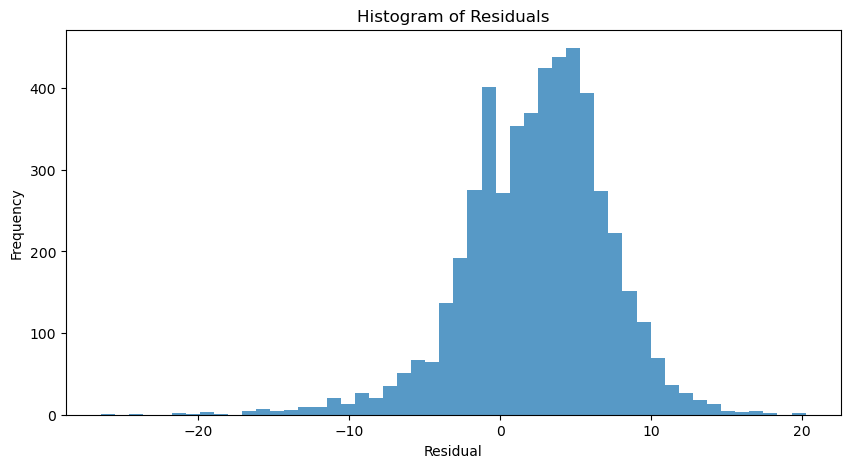

In [12]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GATv2Conv
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import random
import itertools
import matplotlib.pyplot as plt

class GATv2_ThreeLayer(torch.nn.Module):
    def __init__(self, in_channels, hidden1, hidden2, hidden3, out_channels, dropout):
        super(GATv2_ThreeLayer, self).__init__()
        self.conv1 = GATv2Conv(in_channels, hidden1, heads=1)
        self.conv2 = GATv2Conv(hidden1, hidden2, heads=1)
        self.conv3 = GATv2Conv(hidden2, hidden3, heads=1)
        self.fc1 = torch.nn.Linear(hidden3, out_channels)
        self.dropout = dropout

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)  # Dropout
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)  # Dropout
        x = self.conv3(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)  # Dropout
        x = self.fc1(x)
        return x

def train(model, optimizer, data):
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = F.mse_loss(out, data.y)
    loss.backward()
    optimizer.step()
    return loss.item()

# 定义超参数空间
param_space = {
    'lr': [0.001, 0.005, 0.01],
    'weight_decay': [5e-4, 1e-3, 5e-3],
    'hidden1': [32, 64, 128],
    'hidden2': [16, 32, 64],
    'hidden3': [8, 16, 32],
    'dropout': [0.3, 0.5, 0.7],
    'num_epochs': [200]
}

# 随机搜索
num_samples = 50  # 选择搜索的参数组合数量
random_params = [dict(zip(param_space, v)) for v in random.sample(list(itertools.product(*param_space.values())), num_samples)]

best_loss = float('inf')
best_params = None

for i, params in enumerate(random_params):
    print(f"Running configuration {i + 1}/{num_samples}: {params}")
    
    model = GATv2_ThreeLayer(
        in_channels=data.x.shape[1], 
        hidden1=params['hidden1'], 
        hidden2=params['hidden2'], 
        hidden3=params['hidden3'], 
        out_channels=data.y.shape[1], 
        dropout=params['dropout']
    )
    optimizer = torch.optim.Adam(model.parameters(), lr=params['lr'], weight_decay=params['weight_decay'])

    losses = []
    for epoch in range(params['num_epochs']):
        loss = train(model, optimizer, data)
        losses.append(loss)

    print(f"Configuration {i + 1}/{num_samples} finished with final loss: {losses[-1]:.4f}")

    if losses[-1] < best_loss:
        best_loss = losses[-1]
        best_params = params

print(f'Best params: {best_params}, Best loss: {best_loss:.4f}')

# 使用最佳超参数重新训练模型
model = GATv2_ThreeLayer(
    in_channels=data.x.shape[1], 
    hidden1=best_params['hidden1'], 
    hidden2=best_params['hidden2'], 
    hidden3=best_params['hidden3'], 
    out_channels=data.y.shape[1], 
    dropout=best_params['dropout']
)
optimizer = torch.optim.Adam(model.parameters(), lr=best_params['lr'], weight_decay=best_params['weight_decay'])

losses = []
for epoch in range(best_params['num_epochs']):
    loss = train(model, optimizer, data)
    losses.append(loss)

# 测试模型并计算评估指标
model.eval()
with torch.no_grad():
    pred = model(data)
    residuals = data.y - pred

# 计算评估指标
y_true = data.y.detach().numpy()
y_pred = pred.detach().numpy()

mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print(f'MSE: {mse:.4f}')
print(f'RMSE: {rmse:.4f}')
print(f'MAE: {mae:.4f}')
print(f'R²: {r2:.4f}')

# 可视化残差
plt.figure(figsize=(10, 5))
plt.hist(residuals.detach().numpy(), bins=50, alpha=0.75)
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals')
plt.show()


## o_hypertension_quantity_per_capita

Best params: {'lr': 0.001, 'weight_decay': 0.005, 'hidden1': 128, 'hidden2': 64, 'dropout': 0.3, 'num_epochs': 200}, Best loss: 432.1085
MSE: 377.6139
RMSE: 19.4323
MAE: 14.9069
R²: 0.6322


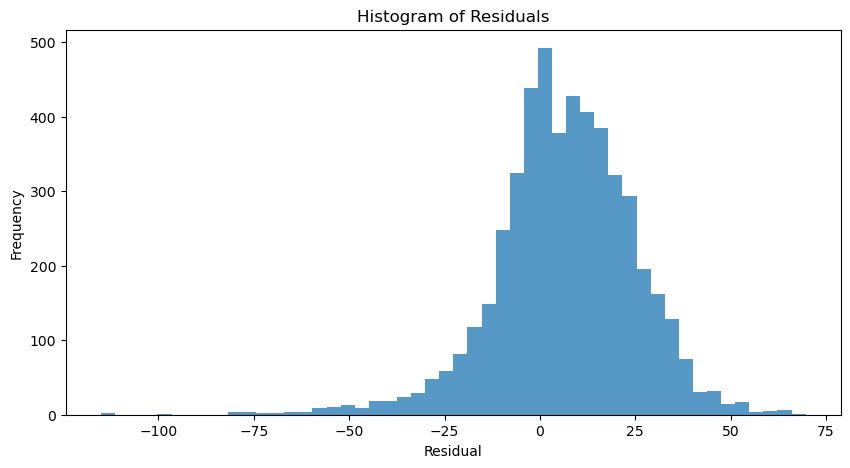

In [15]:
# 定义GIN模型
class GIN(torch.nn.Module):
    def __init__(self, in_channels, hidden1, hidden2, out_channels, dropout):
        super(GIN, self).__init__()
        nn1 = torch.nn.Sequential(torch.nn.Linear(in_channels, hidden1), torch.nn.ReLU(), torch.nn.Linear(hidden1, hidden1))
        self.conv1 = GINConv(nn1)
        nn2 = torch.nn.Sequential(torch.nn.Linear(hidden1, hidden2), torch.nn.ReLU(), torch.nn.Linear(hidden2, hidden2))
        self.conv2 = GINConv(nn2)
        self.fc1 = torch.nn.Linear(hidden2, out_channels)
        self.dropout = dropout

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.fc1(x)
        return x

# 训练函数
def train(model, optimizer, data):
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = F.mse_loss(out, data.y)
    loss.backward()
    optimizer.step()
    return loss.item()

# 定义超参数空间
param_space = {
    'lr': [0.001, 0.005, 0.01],
    'weight_decay': [5e-4, 1e-3, 5e-3],
    'hidden1': [32, 64, 128],
    'hidden2': [16, 32, 64],
    'dropout': [0.3, 0.5, 0.7],
    'num_epochs': [100, 200]
}

# 随机搜索
num_samples = 20
random_params = [dict(zip(param_space, v)) for v in random.sample(list(itertools.product(*param_space.values())), num_samples)]

best_loss = float('inf')
best_params = None

for params in random_params:
    model = GIN(
        in_channels=data.x.shape[1], 
        hidden1=params['hidden1'], 
        hidden2=params['hidden2'], 
        out_channels=data.y.shape[1], 
        dropout=params['dropout']
    )
    optimizer = torch.optim.Adam(model.parameters(), lr=params['lr'], weight_decay=params['weight_decay'])

    losses = []
    for epoch in range(params['num_epochs']):
        loss = train(model, optimizer, data)
        losses.append(loss)

    if losses[-1] < best_loss:
        best_loss = losses[-1]
        best_params = params

print(f'Best params: {best_params}, Best loss: {best_loss:.4f}')

# 使用最佳超参数重新训练模型
model = GIN(
    in_channels=data.x.shape[1], 
    hidden1=best_params['hidden1'], 
    hidden2=best_params['hidden2'], 
    out_channels=data.y.shape[1], 
    dropout=best_params['dropout']
)
optimizer = torch.optim.Adam(model.parameters(), lr=best_params['lr'], weight_decay=best_params['weight_decay'])

losses = []
for epoch in range(best_params['num_epochs']):
    loss = train(model, optimizer, data)
    losses.append(loss)

# 测试模型并计算评估指标
model.eval()
with torch.no_grad():
    pred = model(data)
    residuals = data.y - pred

# 计算评估指标
y_true = data.y.detach().numpy()
y_pred = pred.detach().numpy()

mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print(f'MSE: {mse:.4f}')
print(f'RMSE: {rmse:.4f}')
print(f'MAE: {mae:.4f}')
print(f'R²: {r2:.4f}')

# 可视化残差
plt.figure(figsize=(10, 5))
plt.hist(residuals.detach().numpy(), bins=50, alpha=0.75)
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals')
plt.show()

## o_asthma_quantity_per_capita

Best params: {'lr': 0.005, 'weight_decay': 0.001, 'hidden1': 32, 'hidden2': 64, 'dropout': 0.3, 'num_epochs': 200}, Best loss: 6.2414
MSE: 5.7106
RMSE: 2.3897
MAE: 1.7932
R²: 0.6727


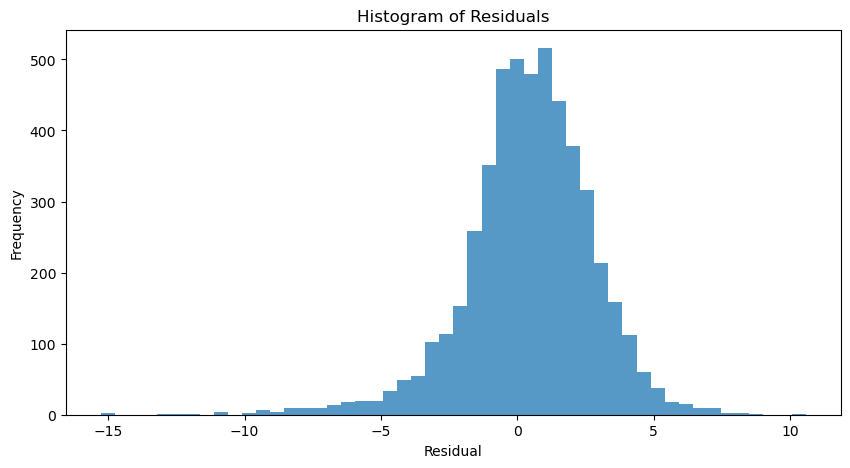

In [17]:
# 定义GIN模型
class GIN(torch.nn.Module):
    def __init__(self, in_channels, hidden1, hidden2, out_channels, dropout):
        super(GIN, self).__init__()
        nn1 = torch.nn.Sequential(torch.nn.Linear(in_channels, hidden1), torch.nn.ReLU(), torch.nn.Linear(hidden1, hidden1))
        self.conv1 = GINConv(nn1)
        nn2 = torch.nn.Sequential(torch.nn.Linear(hidden1, hidden2), torch.nn.ReLU(), torch.nn.Linear(hidden2, hidden2))
        self.conv2 = GINConv(nn2)
        self.fc1 = torch.nn.Linear(hidden2, out_channels)
        self.dropout = dropout

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.fc1(x)
        return x

# 训练函数
def train(model, optimizer, data):
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = F.mse_loss(out, data.y)
    loss.backward()
    optimizer.step()
    return loss.item()

# 定义超参数空间
param_space = {
    'lr': [0.001, 0.005, 0.01],
    'weight_decay': [5e-4, 1e-3, 5e-3],
    'hidden1': [32, 64, 128],
    'hidden2': [16, 32, 64],
    'dropout': [0.3, 0.5, 0.7],
    'num_epochs': [100, 200]
}

# 随机搜索
num_samples = 20
random_params = [dict(zip(param_space, v)) for v in random.sample(list(itertools.product(*param_space.values())), num_samples)]

best_loss = float('inf')
best_params = None

for params in random_params:
    model = GIN(
        in_channels=data.x.shape[1], 
        hidden1=params['hidden1'], 
        hidden2=params['hidden2'], 
        out_channels=data.y.shape[1], 
        dropout=params['dropout']
    )
    optimizer = torch.optim.Adam(model.parameters(), lr=params['lr'], weight_decay=params['weight_decay'])

    losses = []
    for epoch in range(params['num_epochs']):
        loss = train(model, optimizer, data)
        losses.append(loss)

    if losses[-1] < best_loss:
        best_loss = losses[-1]
        best_params = params

print(f'Best params: {best_params}, Best loss: {best_loss:.4f}')

# 使用最佳超参数重新训练模型
model = GIN(
    in_channels=data.x.shape[1], 
    hidden1=best_params['hidden1'], 
    hidden2=best_params['hidden2'], 
    out_channels=data.y.shape[1], 
    dropout=best_params['dropout']
)
optimizer = torch.optim.Adam(model.parameters(), lr=best_params['lr'], weight_decay=best_params['weight_decay'])

losses = []
for epoch in range(best_params['num_epochs']):
    loss = train(model, optimizer, data)
    losses.append(loss)

# 测试模型并计算评估指标
model.eval()
with torch.no_grad():
    pred = model(data)
    residuals = data.y - pred

# 计算评估指标
y_true = data.y.detach().numpy()
y_pred = pred.detach().numpy()

mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print(f'MSE: {mse:.4f}')
print(f'RMSE: {rmse:.4f}')
print(f'MAE: {mae:.4f}')
print(f'R²: {r2:.4f}')

# 可视化残差
plt.figure(figsize=(10, 5))
plt.hist(residuals.detach().numpy(), bins=50, alpha=0.75)
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals')
plt.show()

## o_OME_per_capita

Best params: {'lr': 0.005, 'weight_decay': 0.0005, 'hidden1': 64, 'hidden2': 32, 'dropout': 0.3, 'num_epochs': 200}, Best loss: 17281.9512
MSE: 13810.1064
RMSE: 117.5164
MAE: 56.2026
R²: 0.7756


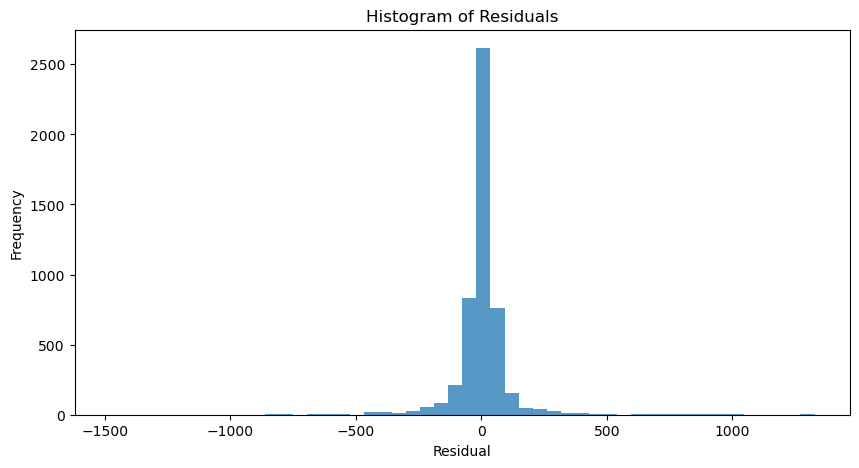

In [22]:
# 定义GIN模型
class GIN(torch.nn.Module):
    def __init__(self, in_channels, hidden1, hidden2, out_channels, dropout):
        super(GIN, self).__init__()
        nn1 = torch.nn.Sequential(torch.nn.Linear(in_channels, hidden1), torch.nn.ReLU(), torch.nn.Linear(hidden1, hidden1))
        self.conv1 = GINConv(nn1)
        nn2 = torch.nn.Sequential(torch.nn.Linear(hidden1, hidden2), torch.nn.ReLU(), torch.nn.Linear(hidden2, hidden2))
        self.conv2 = GINConv(nn2)
        self.fc1 = torch.nn.Linear(hidden2, out_channels)
        self.dropout = dropout

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.fc1(x)
        return x

# 训练函数
def train(model, optimizer, data):
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = F.mse_loss(out, data.y)
    loss.backward()
    optimizer.step()
    return loss.item()

# 定义超参数空间
param_space = {
    'lr': [0.001, 0.005, 0.01],
    'weight_decay': [5e-4, 1e-3, 5e-3],
    'hidden1': [32, 64, 128],
    'hidden2': [16, 32, 64],
    'dropout': [0.3, 0.5, 0.7],
    'num_epochs': [100, 200]
}

# 随机搜索
num_samples = 20
random_params = [dict(zip(param_space, v)) for v in random.sample(list(itertools.product(*param_space.values())), num_samples)]

best_loss = float('inf')
best_params = None

for params in random_params:
    model = GIN(
        in_channels=data.x.shape[1], 
        hidden1=params['hidden1'], 
        hidden2=params['hidden2'], 
        out_channels=data.y.shape[1], 
        dropout=params['dropout']
    )
    optimizer = torch.optim.Adam(model.parameters(), lr=params['lr'], weight_decay=params['weight_decay'])

    losses = []
    for epoch in range(params['num_epochs']):
        loss = train(model, optimizer, data)
        losses.append(loss)

    if losses[-1] < best_loss:
        best_loss = losses[-1]
        best_params = params

print(f'Best params: {best_params}, Best loss: {best_loss:.4f}')

# 使用最佳超参数重新训练模型
model = GIN(
    in_channels=data.x.shape[1], 
    hidden1=best_params['hidden1'], 
    hidden2=best_params['hidden2'], 
    out_channels=data.y.shape[1], 
    dropout=best_params['dropout']
)
optimizer = torch.optim.Adam(model.parameters(), lr=best_params['lr'], weight_decay=best_params['weight_decay'])

losses = []
for epoch in range(best_params['num_epochs']):
    loss = train(model, optimizer, data)
    losses.append(loss)

# 测试模型并计算评估指标
model.eval()
with torch.no_grad():
    pred = model(data)
    residuals = data.y - pred

# 计算评估指标
y_true = data.y.detach().numpy()
y_pred = pred.detach().numpy()

mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print(f'MSE: {mse:.4f}')
print(f'RMSE: {rmse:.4f}')
print(f'MAE: {mae:.4f}')
print(f'R²: {r2:.4f}')

# 可视化残差
plt.figure(figsize=(10, 5))
plt.hist(residuals.detach().numpy(), bins=50, alpha=0.75)
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals')
plt.show()

## o_opioids_quantity_per_capita

Best params: {'lr': 0.005, 'weight_decay': 0.0005, 'hidden1': 64, 'hidden2': 32, 'dropout': 0.3, 'num_epochs': 200}, Best loss: 12.8892
MSE: 9.3517
RMSE: 3.0581
MAE: 2.2121
R²: 0.7109


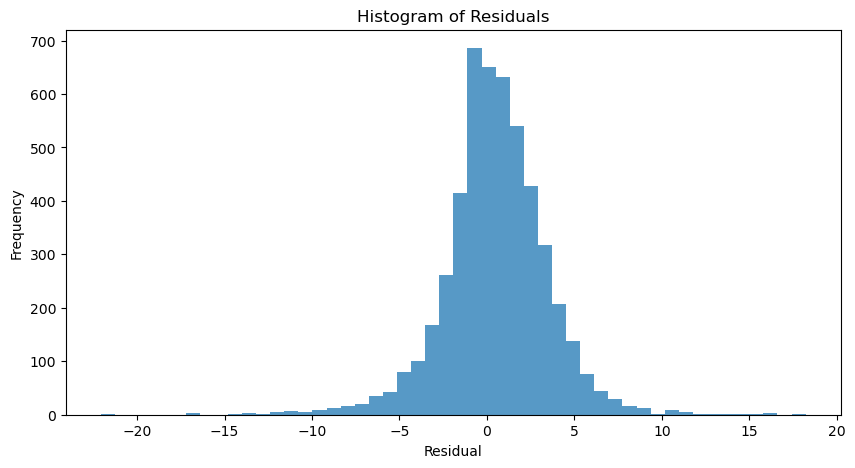

In [24]:
# 定义GIN模型
class GIN(torch.nn.Module):
    def __init__(self, in_channels, hidden1, hidden2, out_channels, dropout):
        super(GIN, self).__init__()
        nn1 = torch.nn.Sequential(torch.nn.Linear(in_channels, hidden1), torch.nn.ReLU(), torch.nn.Linear(hidden1, hidden1))
        self.conv1 = GINConv(nn1)
        nn2 = torch.nn.Sequential(torch.nn.Linear(hidden1, hidden2), torch.nn.ReLU(), torch.nn.Linear(hidden2, hidden2))
        self.conv2 = GINConv(nn2)
        self.fc1 = torch.nn.Linear(hidden2, out_channels)
        self.dropout = dropout

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.fc1(x)
        return x

# 训练函数
def train(model, optimizer, data):
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = F.mse_loss(out, data.y)
    loss.backward()
    optimizer.step()
    return loss.item()

# 定义超参数空间
param_space = {
    'lr': [0.001, 0.005, 0.01],
    'weight_decay': [5e-4, 1e-3, 5e-3],
    'hidden1': [32, 64, 128],
    'hidden2': [16, 32, 64],
    'dropout': [0.3, 0.5, 0.7],
    'num_epochs': [100, 200]
}

# 随机搜索
num_samples = 20
random_params = [dict(zip(param_space, v)) for v in random.sample(list(itertools.product(*param_space.values())), num_samples)]

best_loss = float('inf')
best_params = None

for params in random_params:
    model = GIN(
        in_channels=data.x.shape[1], 
        hidden1=params['hidden1'], 
        hidden2=params['hidden2'], 
        out_channels=data.y.shape[1], 
        dropout=params['dropout']
    )
    optimizer = torch.optim.Adam(model.parameters(), lr=params['lr'], weight_decay=params['weight_decay'])

    losses = []
    for epoch in range(params['num_epochs']):
        loss = train(model, optimizer, data)
        losses.append(loss)

    if losses[-1] < best_loss:
        best_loss = losses[-1]
        best_params = params

print(f'Best params: {best_params}, Best loss: {best_loss:.4f}')

# 使用最佳超参数重新训练模型
model = GIN(
    in_channels=data.x.shape[1], 
    hidden1=best_params['hidden1'], 
    hidden2=best_params['hidden2'], 
    out_channels=data.y.shape[1], 
    dropout=best_params['dropout']
)
optimizer = torch.optim.Adam(model.parameters(), lr=best_params['lr'], weight_decay=best_params['weight_decay'])

losses = []
for epoch in range(best_params['num_epochs']):
    loss = train(model, optimizer, data)
    losses.append(loss)

# 测试模型并计算评估指标
model.eval()
with torch.no_grad():
    pred = model(data)
    residuals = data.y - pred

# 计算评估指标
y_true = data.y.detach().numpy()
y_pred = pred.detach().numpy()

mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print(f'MSE: {mse:.4f}')
print(f'RMSE: {rmse:.4f}')
print(f'MAE: {mae:.4f}')
print(f'R²: {r2:.4f}')

# 可视化残差
plt.figure(figsize=(10, 5))
plt.hist(residuals.detach().numpy(), bins=50, alpha=0.75)
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals')
plt.show()

## o_diabetes_quantity_per_capita

Best params: {'lr': 0.005, 'weight_decay': 0.0005, 'hidden1': 128, 'hidden2': 32, 'dropout': 0.3, 'num_epochs': 200}, Best loss: 194.9078
MSE: 154.2563
RMSE: 12.4200
MAE: 9.1238
R²: 0.6590


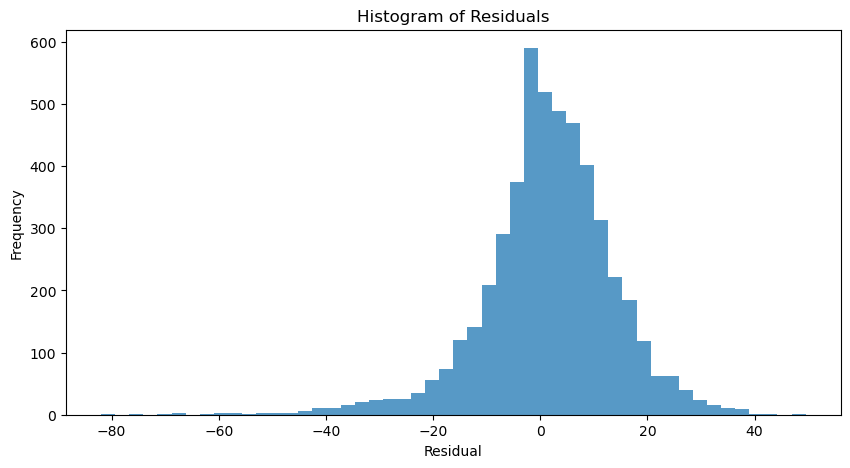

In [26]:
# 定义GIN模型
class GIN(torch.nn.Module):
    def __init__(self, in_channels, hidden1, hidden2, out_channels, dropout):
        super(GIN, self).__init__()
        nn1 = torch.nn.Sequential(torch.nn.Linear(in_channels, hidden1), torch.nn.ReLU(), torch.nn.Linear(hidden1, hidden1))
        self.conv1 = GINConv(nn1)
        nn2 = torch.nn.Sequential(torch.nn.Linear(hidden1, hidden2), torch.nn.ReLU(), torch.nn.Linear(hidden2, hidden2))
        self.conv2 = GINConv(nn2)
        self.fc1 = torch.nn.Linear(hidden2, out_channels)
        self.dropout = dropout

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.fc1(x)
        return x

# 训练函数
def train(model, optimizer, data):
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = F.mse_loss(out, data.y)
    loss.backward()
    optimizer.step()
    return loss.item()

# 定义超参数空间
param_space = {
    'lr': [0.001, 0.005, 0.01],
    'weight_decay': [5e-4, 1e-3, 5e-3],
    'hidden1': [32, 64, 128],
    'hidden2': [16, 32, 64],
    'dropout': [0.3, 0.5, 0.7],
    'num_epochs': [100, 200]
}

# 随机搜索
num_samples = 20
random_params = [dict(zip(param_space, v)) for v in random.sample(list(itertools.product(*param_space.values())), num_samples)]

best_loss = float('inf')
best_params = None

for params in random_params:
    model = GIN(
        in_channels=data.x.shape[1], 
        hidden1=params['hidden1'], 
        hidden2=params['hidden2'], 
        out_channels=data.y.shape[1], 
        dropout=params['dropout']
    )
    optimizer = torch.optim.Adam(model.parameters(), lr=params['lr'], weight_decay=params['weight_decay'])

    losses = []
    for epoch in range(params['num_epochs']):
        loss = train(model, optimizer, data)
        losses.append(loss)

    if losses[-1] < best_loss:
        best_loss = losses[-1]
        best_params = params

print(f'Best params: {best_params}, Best loss: {best_loss:.4f}')

# 使用最佳超参数重新训练模型
model = GIN(
    in_channels=data.x.shape[1], 
    hidden1=best_params['hidden1'], 
    hidden2=best_params['hidden2'], 
    out_channels=data.y.shape[1], 
    dropout=best_params['dropout']
)
optimizer = torch.optim.Adam(model.parameters(), lr=best_params['lr'], weight_decay=best_params['weight_decay'])

losses = []
for epoch in range(best_params['num_epochs']):
    loss = train(model, optimizer, data)
    losses.append(loss)

# 测试模型并计算评估指标
model.eval()
with torch.no_grad():
    pred = model(data)
    residuals = data.y - pred

# 计算评估指标
y_true = data.y.detach().numpy()
y_pred = pred.detach().numpy()

mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print(f'MSE: {mse:.4f}')
print(f'RMSE: {rmse:.4f}')
print(f'MAE: {mae:.4f}')
print(f'R²: {r2:.4f}')

# 可视化残差
plt.figure(figsize=(10, 5))
plt.hist(residuals.detach().numpy(), bins=50, alpha=0.75)
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals')
plt.show()

## o_anxiety_quantity_per_capita

Best params: {'lr': 0.01, 'weight_decay': 0.001, 'hidden1': 64, 'hidden2': 64, 'dropout': 0.3, 'num_epochs': 200}, Best loss: 48.7563
MSE: 44.8334
RMSE: 6.6958
MAE: 5.0909
R²: 0.7281


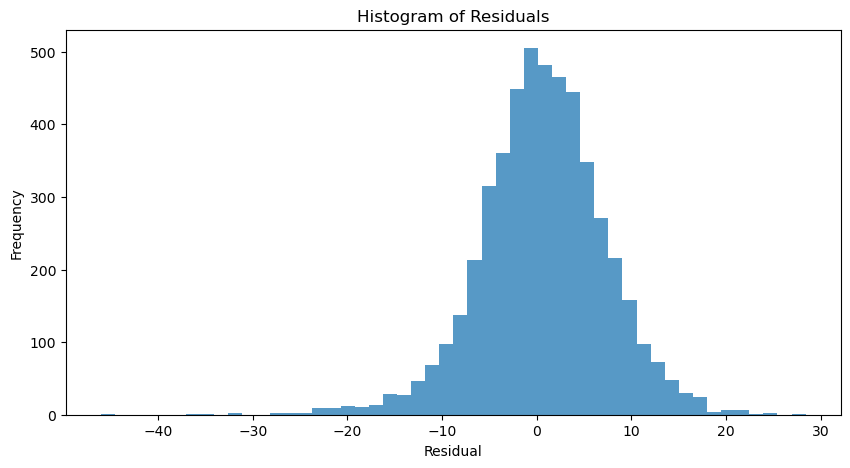

In [26]:
# 定义GIN模型
class GIN(torch.nn.Module):
    def __init__(self, in_channels, hidden1, hidden2, out_channels, dropout):
        super(GIN, self).__init__()
        nn1 = torch.nn.Sequential(torch.nn.Linear(in_channels, hidden1), torch.nn.ReLU(), torch.nn.Linear(hidden1, hidden1))
        self.conv1 = GINConv(nn1)
        nn2 = torch.nn.Sequential(torch.nn.Linear(hidden1, hidden2), torch.nn.ReLU(), torch.nn.Linear(hidden2, hidden2))
        self.conv2 = GINConv(nn2)
        self.fc1 = torch.nn.Linear(hidden2, out_channels)
        self.dropout = dropout

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.fc1(x)
        return x

# 训练函数
def train(model, optimizer, data):
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = F.mse_loss(out, data.y)
    loss.backward()
    optimizer.step()
    return loss.item()

# 定义超参数空间
param_space = {
    'lr': [0.001, 0.005, 0.01],
    'weight_decay': [5e-4, 1e-3, 5e-3],
    'hidden1': [32, 64, 128],
    'hidden2': [16, 32, 64],
    'dropout': [0.3, 0.5, 0.7],
    'num_epochs': [100, 200]
}

# 随机搜索
num_samples = 20
random_params = [dict(zip(param_space, v)) for v in random.sample(list(itertools.product(*param_space.values())), num_samples)]

best_loss = float('inf')
best_params = None

for params in random_params:
    model = GIN(
        in_channels=data.x.shape[1], 
        hidden1=params['hidden1'], 
        hidden2=params['hidden2'], 
        out_channels=data.y.shape[1], 
        dropout=params['dropout']
    )
    optimizer = torch.optim.Adam(model.parameters(), lr=params['lr'], weight_decay=params['weight_decay'])

    losses = []
    for epoch in range(params['num_epochs']):
        loss = train(model, optimizer, data)
        losses.append(loss)

    if losses[-1] < best_loss:
        best_loss = losses[-1]
        best_params = params

print(f'Best params: {best_params}, Best loss: {best_loss:.4f}')

# 使用最佳超参数重新训练模型
model = GIN(
    in_channels=data.x.shape[1], 
    hidden1=best_params['hidden1'], 
    hidden2=best_params['hidden2'], 
    out_channels=data.y.shape[1], 
    dropout=best_params['dropout']
)
optimizer = torch.optim.Adam(model.parameters(), lr=best_params['lr'], weight_decay=best_params['weight_decay'])

losses = []
for epoch in range(best_params['num_epochs']):
    loss = train(model, optimizer, data)
    losses.append(loss)

# 测试模型并计算评估指标
model.eval()
with torch.no_grad():
    pred = model(data)
    residuals = data.y - pred

# 计算评估指标
y_true = data.y.detach().numpy()
y_pred = pred.detach().numpy()

mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print(f'MSE: {mse:.4f}')
print(f'RMSE: {rmse:.4f}')
print(f'MAE: {mae:.4f}')
print(f'R²: {r2:.4f}')

# 可视化残差
plt.figure(figsize=(10, 5))
plt.hist(residuals.detach().numpy(), bins=50, alpha=0.75)
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals')
plt.show()

Best params: {'lr': 0.01, 'weight_decay': 0.001, 'hidden1': 128, 'hidden2': 64, 'dropout': 0.5, 'num_epochs': 200}, Best loss: 78.2762
MSE: 52.8899
RMSE: 7.2725
MAE: 5.4699
R²: 0.6793


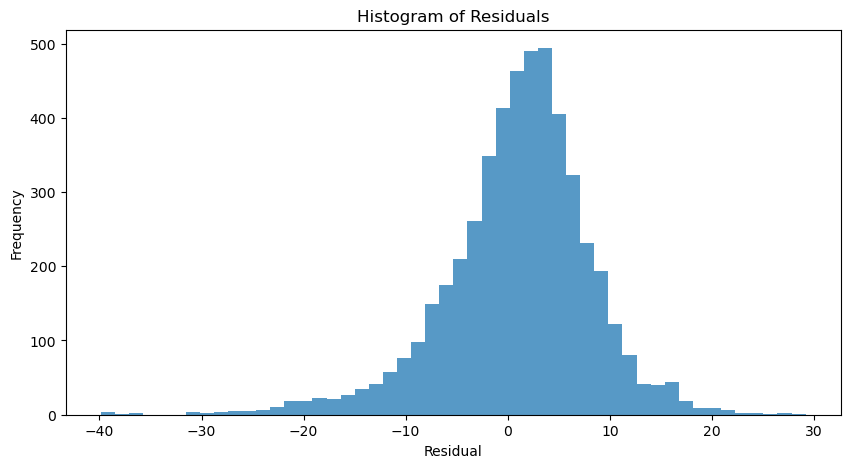

In [25]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GATConv
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import random
import itertools

class GAT(torch.nn.Module):
    def __init__(self, in_channels, hidden1, hidden2, out_channels, dropout, heads=1):
        super(GAT, self).__init__()
        self.conv1 = GATConv(in_channels, hidden1, heads=heads, dropout=dropout)
        self.conv2 = GATConv(hidden1 * heads, hidden2, heads=heads, dropout=dropout)
        self.fc1 = torch.nn.Linear(hidden2 * heads, out_channels)
        self.dropout = dropout

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)  # Dropout
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)  # Dropout
        x = self.fc1(x)
        return x

def train(model, optimizer, data):
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = F.mse_loss(out, data.y)
    loss.backward()
    optimizer.step()
    return loss.item()

# 定义超参数空间
param_space = {
    'lr': [0.001, 0.005, 0.01],
    'weight_decay': [5e-4, 1e-3, 5e-3],
    'hidden1': [32, 64, 128],
    'hidden2': [16, 32, 64],
    'dropout': [0.3, 0.5, 0.7],
    'num_epochs': [100, 200]
}

# 随机搜索
num_samples = 20  # 选择搜索的参数组合数量
random_params = [dict(zip(param_space, v)) for v in random.sample(list(itertools.product(*param_space.values())), num_samples)]

best_loss = float('inf')
best_params = None

for params in random_params:
    model = GAT(
        in_channels=data.x.shape[1], 
        hidden1=params['hidden1'], 
        hidden2=params['hidden2'], 
        out_channels=data.y.shape[1], 
        dropout=params['dropout']
    )
    optimizer = torch.optim.Adam(model.parameters(), lr=params['lr'], weight_decay=params['weight_decay'])

    losses = []
    for epoch in range(params['num_epochs']):
        loss = train(model, optimizer, data)
        losses.append(loss)

    if losses[-1] < best_loss:
        best_loss = losses[-1]
        best_params = params

print(f'Best params: {best_params}, Best loss: {best_loss:.4f}')

# 使用最佳超参数重新训练模型
model = GAT(
    in_channels=data.x.shape[1], 
    hidden1=best_params['hidden1'], 
    hidden2=best_params['hidden2'], 
    out_channels=data.y.shape[1], 
    dropout=best_params['dropout']
)
optimizer = torch.optim.Adam(model.parameters(), lr=best_params['lr'], weight_decay=best_params['weight_decay'])

losses = []
for epoch in range(best_params['num_epochs']):
    loss = train(model, optimizer, data)
    losses.append(loss)

# 测试模型并计算评估指标
model.eval()
with torch.no_grad():
    pred = model(data)
    residuals = data.y - pred

# 计算评估指标
y_true = data.y.detach().numpy()
y_pred = pred.detach().numpy()

mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print(f'MSE: {mse:.4f}')
print(f'RMSE: {rmse:.4f}')
print(f'MAE: {mae:.4f}')
print(f'R²: {r2:.4f}')

# 可视化残差
plt.figure(figsize=(10, 5))
plt.hist(residuals.detach().numpy(), bins=50, alpha=0.75)
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals')
plt.show()

Best params: {'lr': 0.01, 'weight_decay': 0.005, 'hidden1': 128, 'hidden2': 64, 'dropout': 0.5, 'num_epochs': 200}, Best loss: 67.1702
MSE: 47.5249
RMSE: 6.8938
MAE: 5.3068
R²: 0.7118


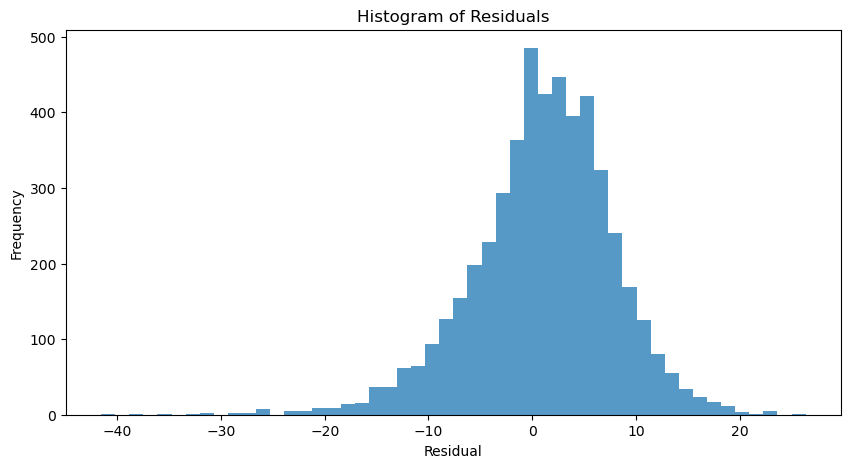

In [22]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import random
import itertools

class GraphSAGE(torch.nn.Module):
    def __init__(self, in_channels, hidden1, hidden2, out_channels, dropout):
        super(GraphSAGE, self).__init__()
        self.conv1 = SAGEConv(in_channels, hidden1)
        self.conv2 = SAGEConv(hidden1, hidden2)
        self.fc1 = torch.nn.Linear(hidden2, out_channels)
        self.dropout = dropout

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)  # Dropout
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)  # Dropout
        x = self.fc1(x)
        return x

def train(model, optimizer, data):
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = F.mse_loss(out, data.y)
    loss.backward()
    optimizer.step()
    return loss.item()

# 定义超参数空间
param_space = {
    'lr': [0.001, 0.005, 0.01],
    'weight_decay': [5e-4, 1e-3, 5e-3],
    'hidden1': [32, 64, 128],
    'hidden2': [16, 32, 64],
    'dropout': [0.3, 0.5, 0.7],
    'num_epochs': [100, 200]
}

# 随机搜索
num_samples = 20  # 选择搜索的参数组合数量
random_params = [dict(zip(param_space, v)) for v in random.sample(list(itertools.product(*param_space.values())), num_samples)]

best_loss = float('inf')
best_params = None

for params in random_params:
    model = GraphSAGE(
        in_channels=data.x.shape[1], 
        hidden1=params['hidden1'], 
        hidden2=params['hidden2'], 
        out_channels=data.y.shape[1], 
        dropout=params['dropout']
    )
    optimizer = torch.optim.Adam(model.parameters(), lr=params['lr'], weight_decay=params['weight_decay'])

    losses = []
    for epoch in range(params['num_epochs']):
        loss = train(model, optimizer, data)
        losses.append(loss)

    if losses[-1] < best_loss:
        best_loss = losses[-1]
        best_params = params

print(f'Best params: {best_params}, Best loss: {best_loss:.4f}')

# 使用最佳超参数重新训练模型
model = GraphSAGE(
    in_channels=data.x.shape[1], 
    hidden1=best_params['hidden1'], 
    hidden2=best_params['hidden2'], 
    out_channels=data.y.shape[1], 
    dropout=best_params['dropout']
)
optimizer = torch.optim.Adam(model.parameters(), lr=best_params['lr'], weight_decay=best_params['weight_decay'])

losses = []
for epoch in range(best_params['num_epochs']):
    loss = train(model, optimizer, data)
    losses.append(loss)

# 测试模型并计算评估指标
model.eval()
with torch.no_grad():
    pred = model(data)
    residuals = data.y - pred

# 计算评估指标
y_true = data.y.detach().numpy()
y_pred = pred.detach().numpy()

mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print(f'MSE: {mse:.4f}')
print(f'RMSE: {rmse:.4f}')
print(f'MAE: {mae:.4f}')
print(f'R²: {r2:.4f}')

# 可视化残差
plt.figure(figsize=(10, 5))
plt.hist(residuals.detach().numpy(), bins=50, alpha=0.75)
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals')
plt.show()

Best params: {'lr': 0.01, 'weight_decay': 0.0005, 'hidden1': 64, 'hidden2': 64, 'dropout': 0.3, 'num_epochs': 200}, Best loss: 67.9179
MSE: 59.4499
RMSE: 7.7104
MAE: 5.9071
R²: 0.6395


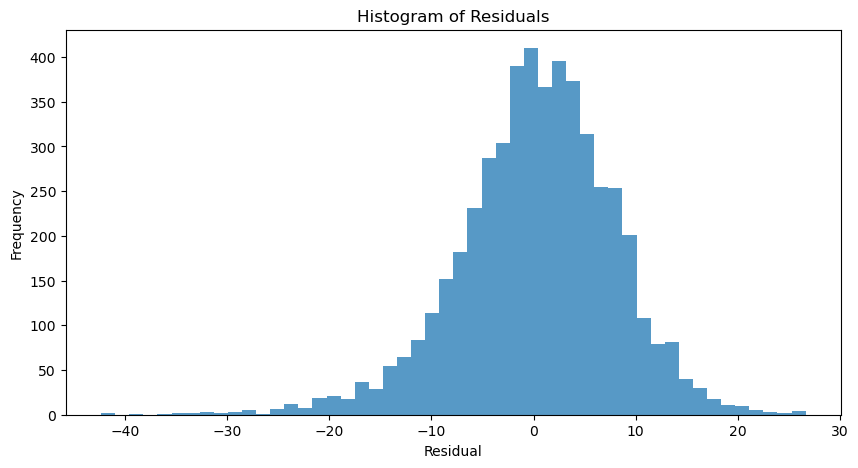

In [23]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import random
import itertools
import matplotlib.pyplot as plt

class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden1, hidden2, out_channels, dropout):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden1)
        self.conv2 = GCNConv(hidden1, hidden2)
        self.fc1 = torch.nn.Linear(hidden2, out_channels)
        self.dropout = dropout

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)  # Dropout
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)  # Dropout
        x = self.fc1(x)
        return x

def train(model, optimizer, data):
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = F.mse_loss(out, data.y)
    loss.backward()
    optimizer.step()
    return loss.item()

# 定义超参数空间
param_space = {
    'lr': [0.001, 0.005, 0.01],
    'weight_decay': [5e-4, 1e-3, 5e-3],
    'hidden1': [32, 64, 128],
    'hidden2': [16, 32, 64],
    'dropout': [0.3, 0.5, 0.7],
    'num_epochs': [100, 200]
}

# 随机搜索
num_samples = 20  # 选择搜索的参数组合数量
random_params = [dict(zip(param_space, v)) for v in random.sample(list(itertools.product(*param_space.values())), num_samples)]

best_loss = float('inf')
best_params = None

for params in random_params:
    model = GCN(
        in_channels=data.x.shape[1], 
        hidden1=params['hidden1'], 
        hidden2=params['hidden2'], 
        out_channels=data.y.shape[1], 
        dropout=params['dropout']
    )
    optimizer = torch.optim.Adam(model.parameters(), lr=params['lr'], weight_decay=params['weight_decay'])

    losses = []
    for epoch in range(params['num_epochs']):
        loss = train(model, optimizer, data)
        losses.append(loss)

    if losses[-1] < best_loss:
        best_loss = losses[-1]
        best_params = params

print(f'Best params: {best_params}, Best loss: {best_loss:.4f}')

# 使用最佳超参数重新训练模型
model = GCN(
    in_channels=data.x.shape[1], 
    hidden1=best_params['hidden1'], 
    hidden2=best_params['hidden2'], 
    out_channels=data.y.shape[1], 
    dropout=best_params['dropout']
)
optimizer = torch.optim.Adam(model.parameters(), lr=best_params['lr'], weight_decay=best_params['weight_decay'])

losses = []
for epoch in range(best_params['num_epochs']):
    loss = train(model, optimizer, data)
    losses.append(loss)

# 测试模型并计算评估指标
model.eval()
with torch.no_grad():
    pred = model(data)
    residuals = data.y - pred

# 计算评估指标
y_true = data.y.detach().numpy()
y_pred = pred.detach().numpy()

mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print(f'MSE: {mse:.4f}')
print(f'RMSE: {rmse:.4f}')
print(f'MAE: {mae:.4f}')
print(f'R²: {r2:.4f}')

# 可视化残差
plt.figure(figsize=(10, 5))
plt.hist(residuals.detach().numpy(), bins=50, alpha=0.75)
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals')
plt.show()


Best params: {'lr': 0.01, 'weight_decay': 0.005, 'hidden1': 128, 'hidden2': 64, 'dropout': 0.3, 'num_epochs': 200}, Best loss: 39.9894
MSE: 30.9700
RMSE: 5.5651
MAE: 4.0366
R²: 0.8122


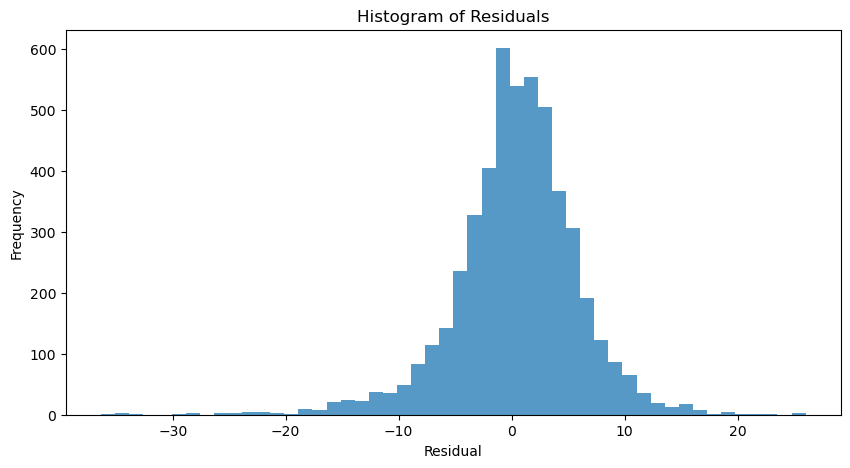

In [6]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GATv2Conv
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import random
import itertools
import matplotlib.pyplot as plt

class GATv2(torch.nn.Module):
    def __init__(self, in_channels, hidden1, hidden2, out_channels, dropout):
        super(GATv2, self).__init__()
        self.conv1 = GATv2Conv(in_channels, hidden1, heads=1)
        self.conv2 = GATv2Conv(hidden1, hidden2, heads=1)
        self.fc1 = torch.nn.Linear(hidden2, out_channels)
        self.dropout = dropout

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)  # Dropout
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)  # Dropout
        x = self.fc1(x)
        return x

def train(model, optimizer, data):
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = F.mse_loss(out, data.y)
    loss.backward()
    optimizer.step()
    return loss.item()

# 定义超参数空间
param_space = {
    'lr': [0.001, 0.005, 0.01],
    'weight_decay': [5e-4, 1e-3, 5e-3],
    'hidden1': [32, 64, 128],
    'hidden2': [16, 32, 64],
    'dropout': [0.3, 0.5, 0.7],
    'num_epochs': [100, 200]
}

# 随机搜索
num_samples = 20  # 选择搜索的参数组合数量
random_params = [dict(zip(param_space, v)) for v in random.sample(list(itertools.product(*param_space.values())), num_samples)]

best_loss = float('inf')
best_params = None

for params in random_params:
    model = GATv2(
        in_channels=data.x.shape[1], 
        hidden1=params['hidden1'], 
        hidden2=params['hidden2'], 
        out_channels=data.y.shape[1], 
        dropout=params['dropout']
    )
    optimizer = torch.optim.Adam(model.parameters(), lr=params['lr'], weight_decay=params['weight_decay'])

    losses = []
    for epoch in range(params['num_epochs']):
        loss = train(model, optimizer, data)
        losses.append(loss)

    if losses[-1] < best_loss:
        best_loss = losses[-1]
        best_params = params

print(f'Best params: {best_params}, Best loss: {best_loss:.4f}')

# 使用最佳超参数重新训练模型
model = GATv2(
    in_channels=data.x.shape[1], 
    hidden1=best_params['hidden1'], 
    hidden2=best_params['hidden2'], 
    out_channels=data.y.shape[1], 
    dropout=best_params['dropout']
)
optimizer = torch.optim.Adam(model.parameters(), lr=best_params['lr'], weight_decay=best_params['weight_decay'])

losses = []
for epoch in range(best_params['num_epochs']):
    loss = train(model, optimizer, data)
    losses.append(loss)

# 测试模型并计算评估指标
model.eval()
with torch.no_grad():
    pred = model(data)
    residuals = data.y - pred

# 计算评估指标
y_true = data.y.detach().numpy()
y_pred = pred.detach().numpy()

mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print(f'MSE: {mse:.4f}')
print(f'RMSE: {rmse:.4f}')
print(f'MAE: {mae:.4f}')
print(f'R²: {r2:.4f}')

# 可视化残差
plt.figure(figsize=(10, 5))
plt.hist(residuals.detach().numpy(), bins=50, alpha=0.75)
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals')
plt.show()

# GNN 解释器

In [66]:
best_params = {'lr': 0.01, 'weight_decay': 0.005, 'hidden1': 128, 'hidden2': 64, 'dropout': 0.3, 'num_epochs': 200}

MSE: 12.1804
RMSE: 3.4900
MAE: 2.6045
R²: 0.8539


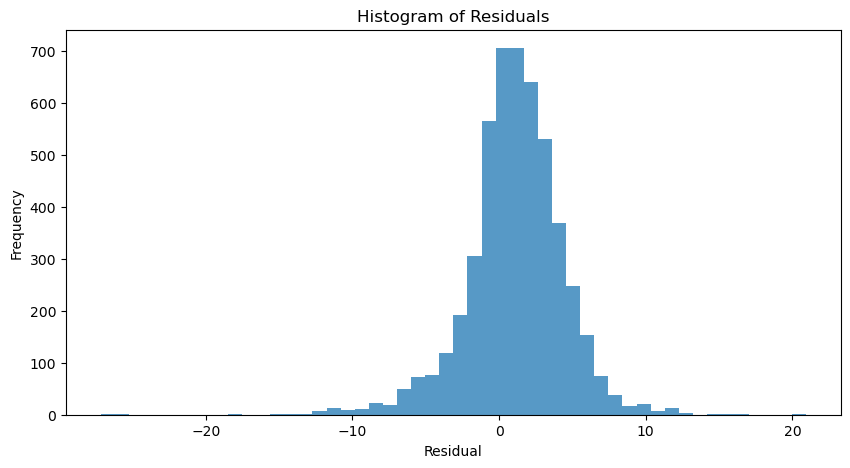

In [67]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GATv2Conv
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import random
import itertools
import matplotlib.pyplot as plt

class GATv2(torch.nn.Module):
    def __init__(self, in_channels, hidden1, hidden2, out_channels, dropout):
        super(GATv2, self).__init__()
        self.conv1 = GATv2Conv(in_channels, hidden1, heads=1)
        self.conv2 = GATv2Conv(hidden1, hidden2, heads=1)
        self.fc1 = torch.nn.Linear(hidden2, out_channels)
        self.dropout = dropout

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)  # Dropout
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)  # Dropout
        x = self.fc1(x)
        return x

def train(model, optimizer, data):
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = F.mse_loss(out, data.y)
    loss.backward()
    optimizer.step()
    return loss.item()


# 使用最佳超参数重新训练模型
model = GATv2(
    in_channels=data.x.shape[1], 
    hidden1=best_params['hidden1'], 
    hidden2=best_params['hidden2'], 
    out_channels=data.y.shape[1], 
    dropout=best_params['dropout']
)
optimizer = torch.optim.Adam(model.parameters(), lr=best_params['lr'], weight_decay=best_params['weight_decay'])

losses = []
for epoch in range(best_params['num_epochs']):
    loss = train(model, optimizer, data)
    losses.append(loss)

# 测试模型并计算评估指标
model.eval()
with torch.no_grad():
    pred = model(data)
    residuals = data.y - pred

# 计算评估指标
y_true = data.y.detach().numpy()
y_pred = pred.detach().numpy()

mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print(f'MSE: {mse:.4f}')
print(f'RMSE: {rmse:.4f}')
print(f'MAE: {mae:.4f}')
print(f'R²: {r2:.4f}')

# 可视化残差
plt.figure(figsize=(10, 5))
plt.hist(residuals.detach().numpy(), bins=50, alpha=0.75)
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals')
plt.show()

In [65]:
data

Data(edge_index=[2, 29472], pos=[4994, 2], weight=[29472], x=[4994, 46], y=[4994, 1])